In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

In [88]:
class Value:
    
    def __init__(self, data, _children = (), _op = '', mark = ''):
        self.data = data
        self.grad = 0.0
        self.kids = _children
        self.actn = _op
        self.mark = mark
        self._back = lambda: None

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other):
        out =  Value(self.data + other.data, ( self, other ), '+')
        def _back():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._back = _back
        return out

    def __sub__(self, other):
        out = Value(self.data - other.data, ( self, other ), '-')
        return out

    def __mul__(self, other):
        out =  Value(self.data * other.data, ( self, other ), '*')
        def _back():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._back = _back
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, ( self, ), 'tanh')
        
        def _back():
            self.grad = (1 - t**2) * out.grad
        out._back = _back
        return out
    
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for c in v.kids:
                    build_topo(c)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._back()
        return self.grad

In [89]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.kids:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.mark, n.data, n.grad), shape='record')
        if n.actn:
            dot.node(name=uid + n.actn, label=n.actn)
            dot.edge(uid + n.actn, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.actn)

    return dot

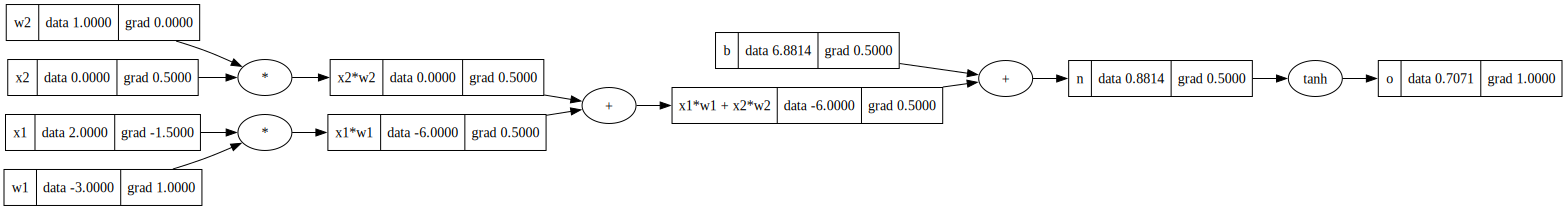

In [92]:
x1 = Value(2.0, mark = 'x1')
x2 = Value(0.0, mark = 'x2')
w1 = Value(-3.0, mark = 'w1')
w2 = Value(1.0, mark = 'w2')
b = Value(6.881373587019543, mark = 'b')
x1w1 = x1 * w1; x1w1.mark = 'x1*w1'
x2w2 = x2 * w2; x2w2.mark = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.mark = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.mark = 'n'
o = n.tanh(); o.mark = 'o'
o.backward()
draw_dot(o)